## Setup evnironment

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from glob import glob
import json

## Setup plotting

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from colorsys import hsv_to_rgb, rgb_to_hsv
%matplotlib inline
#import seaborn as sns
#sns.set_context('paper')
#sns.set_style('ticks')

## Load behavior

Load in mazes, for each maze list branches and whether rewarded or not, also list reward patch size, and get name

In [4]:
def loadMazeMat(path):
    config = sio.loadmat(os.path.join(path,'maze_config.mat'), variable_names = ('maze_array'))
    numMazes = config['maze_array'].shape[0]
    maze = []
    for m in range(0,numMazes):
        nameMaze = config['maze_array'][m][3][0]
        print nameMaze
        numBranches = config['maze_array'][m][0]['num_branches'][0][0][0][0]
        leftBranch = config['maze_array'][m][0]['left_wall_traj'][0][0]
        rightBranch = config['maze_array'][m][0]['right_wall_traj'][0][0]
        rightBranch = config['maze_array'][m][0]['right_wall_traj'][0][0]
        xCord = np.concatenate((leftBranch[:,[0,2]],rightBranch[:,[2,0]]),1)
        yCord = np.concatenate((leftBranch[:,[1,3]],rightBranch[:,[3,1]]),1)
        branches = np.concatenate((np.expand_dims(xCord,0),np.expand_dims(yCord,0)), axis=0).transpose(1, 0, 2)
        branches = branches.tolist()
        rewardBranches = config['maze_array'][m][0]['reward_branch'][0][0]
        rewardPatch = config['maze_array'][m][0]['default_reward_patch'][0][0][0]
        reward = []
        for b in range(0,numBranches):
            if rewardBranches[b][0]:
                y1 = branches[b][1][0]*(1-rewardPatch[2])+branches[b][1][1]*rewardPatch[2] #start y
                y2 = branches[b][1][0]*(1-rewardPatch[3])+branches[b][1][1]*rewardPatch[3] #end y 
                xL1 = branches[b][0][0]*(1-rewardPatch[2])+branches[b][0][1]*rewardPatch[2] #start x left pos
                xL2 = branches[b][0][0]*(1-rewardPatch[3])+branches[b][0][1]*rewardPatch[3] #end x left pos
                xR1 = branches[b][0][3]*(1-rewardPatch[2])+branches[b][0][2]*rewardPatch[2] #start x right pos
                xR2 = branches[b][0][3]*(1-rewardPatch[3])+branches[b][0][2]*rewardPatch[3] #end x right pos
                w1 = xR1-xL1 #start width
                w2 = xR2-xL2 #end width
                xCord = [xL1+rewardPatch[0]*w1, xL2+rewardPatch[0]*w2, xL2+rewardPatch[1]*w2, xL1+rewardPatch[1]*w1]
                yCord = [y1, y2, y2, y1]
                patch = [xCord, yCord]
                reward.append(patch)
        d = {'branches':branches, 'rewards':reward, 'name':nameMaze}
        maze.append(d)
    return maze

In [5]:
def draw(maze,label):
    for b in range(0,len(maze['branches'])):
        branch = maze['branches'][b]
        plt.fill(branch[0], branch[1], edgecolor=[0.7,0.7,0.7], facecolor=[0.7,0.7,0.7], lw=1.5);
        if label:
            plt.text(np.mean(branch[0]), np.mean(branch[1]), '%d' % b, size=14, color=[.2, .2, .8])
    for patch in maze['rewards']:
        plt.fill(patch[0], patch[1], edgecolor=[0.9,0.9,0.9], facecolor=[0.9,0.9,0.9], lw=1.5);
    plt.axis('off')

In [6]:
def trace(covariates, trial, col='random'):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    for t in trial:
        xCord = covariates.yMazePos[covariates.number == t]
        yCord = covariates.xMazePos[covariates.number == t]
        if col == 'random':
            plt.plot(xCord, yCord);
        else:
            plt.plot(xCord, yCord, color=col);

In [7]:
def traceNorm(covariates, trial, col='random'):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    for t in trial:
        xCord = covariates.corNorm[covariates.number == t]
        yCord = covariates.xMazePos[covariates.number == t]
        if col == 'random':
            plt.plot(xCord, yCord);
        else:
            plt.plot(xCord, yCord, color=col);

In [8]:
def licks(covariates, trial, col='random'):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    for t in trial:
        xCord = covariates.yMazePos[(covariates.number == t) & covariates.licks]
        yCord = covariates.xMazePos[(covariates.number == t) & covariates.licks]
        if col == 'random':
            plt.plot(xCord, yCord,'.');
        else:
            plt.plot(xCord, yCord, '.', color=col);

In [9]:
def water(covariates, trial, col='random'):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    for t in trial:
        xCord = covariates.yMazePos[(covariates.number == t) & (covariates.extWater.astype('Bool') | covariates.reward.astype('Bool')) ]
        yCord = covariates.xMazePos[(covariates.number == t) & (covariates.extWater.astype('Bool') | covariates.reward.astype('Bool')) ]
        if col == 'random':
            plt.plot(xCord, yCord,'.');
        else:
            plt.plot(xCord, yCord, '.', color=col);

In [10]:
def getInfo(anm, date, run):
    info = {"contributors": ["Nicholas Sofroniew"],
    "probe": "none",
    "lab": "Svoboda Lab",
    "id": 'Anm_0' + anm,
    "date":date,
    "run":run,
    "animal-state": "Awake head-fixed",
    "experiment": "Tactile Virtual Reality",
    "location": "Janelia Research Campus",
    "animal": "Mouse",
    "method": "Behaviour only"}
    return info

## Load trial data

In [15]:
path = '/Volumes/freeman/Nick/mVR/sessions/000038'
#path = '/Users/sofroniewn/Documents/DATA/mVR/sessions/000038'

In [16]:
files = glob(path + '/behavior/trial-*.csv')
files.sort()
trials = [pd.read_csv(x) for x in files]

Create session table

In [17]:
session = pd.concat(trials)
session.reset_index(inplace=True)
session.rename(columns={'index': 'tick'}, inplace=True)

Add global time

In [18]:
trial = session.groupby(['number']).last()
offsets = np.concatenate(([0],trial.time.values))
offsets = np.cumsum(offsets)
session['allTime'] = session.time + offsets[session.number]

Add filtered speed

In [19]:
speed = (session.xSpeed.pow(2)+session.ySpeed.pow(2)).pow(.5)
session['speed'] = np.convolve(speed,np.ones(50)/50, mode='same')    

Add normalized corridor position

In [20]:
session['corNorm'] = 1 - session.corPos/session.corWidth

Shift to zero index

In [21]:
session['trialType'] = session['trialType']-1
session['curBranchId'] = session['curBranchId']-1
session['trialIndex'] = session.index
session['number'] = session['number']-1

In [22]:
tmp = session.xMazePos.values
tmp[np.where(session.iti.values)] = np.NaN
session.xMazePos = tmp

In [23]:
tmp = session.yMazePos.values
tmp[np.where(session.iti.values)] = np.NaN
session.yMazePos = tmp

In [24]:
session.to_csv(path + '/behavior/session.csv')

##Load maze data

In [25]:
maze = loadMazeMat(path + '/behavior')

OneChoiceLcts.mat


#### Create trial summary

In [26]:
trial = session[['trialType','number']].groupby(['number'], sort=True).first()
trial = trial.join(session[['reward','number','rEnd','lEnd']].groupby(['number'], sort=True).max())

In [27]:
def trialEntered(branchId):
    keep = session[['curBranchId','number']].groupby(['number'], sort=True).agg(lambda x : branchId in x.values)
    return keep

## Plot data

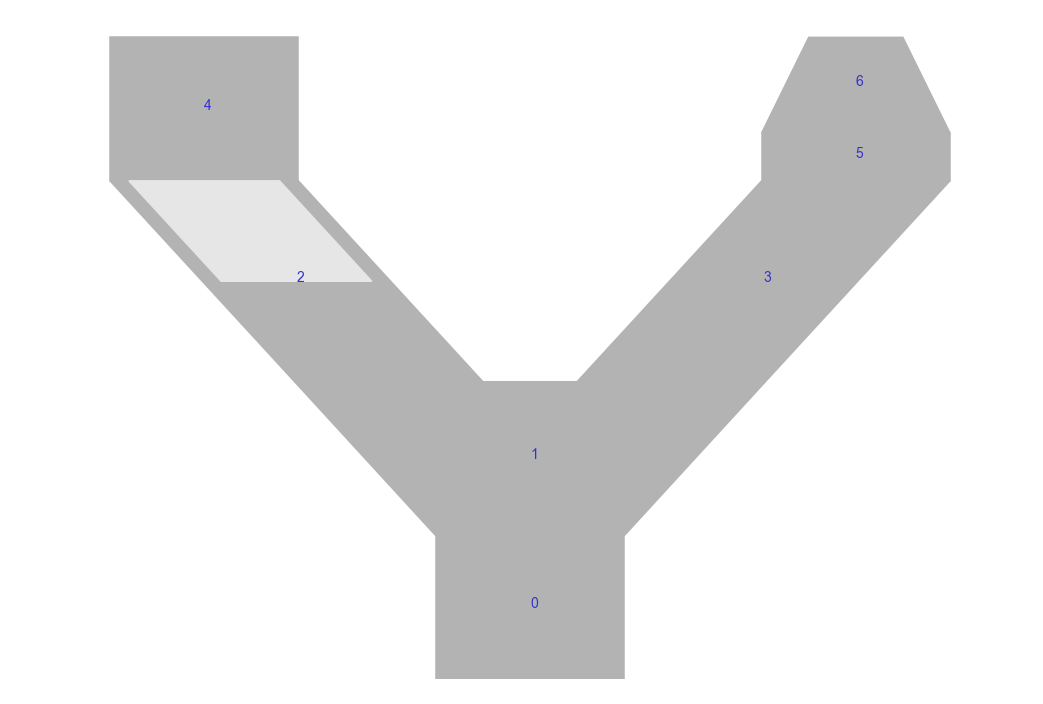

In [29]:
plt.figure(figsize=[18,12])
Id = 0
draw(maze[Id],True)

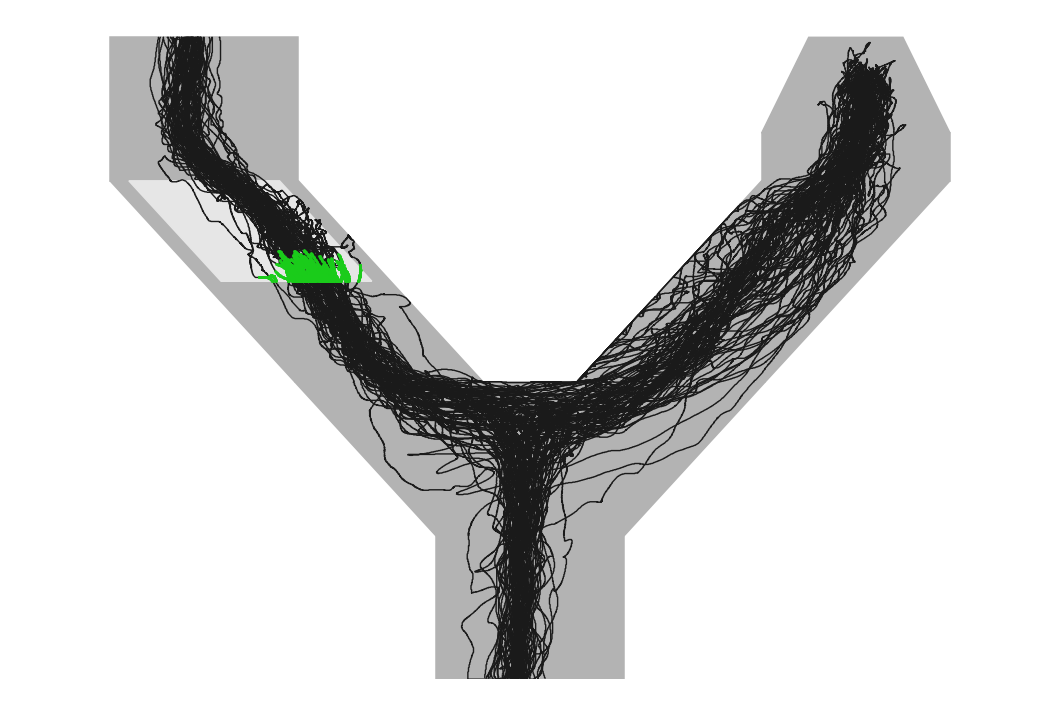

In [32]:
plt.figure(figsize=[18,12])
Id = 0
keep = trial[trial.trialType == Id].index.tolist()
draw(maze[Id],False)
trace(session, keep, [0.1, 0.1, 0.1])
#licks(session, keep, [0.9, 0.1, 0.1])
water(session, keep, [0.1, 0.8, 0.1])

37
5
47


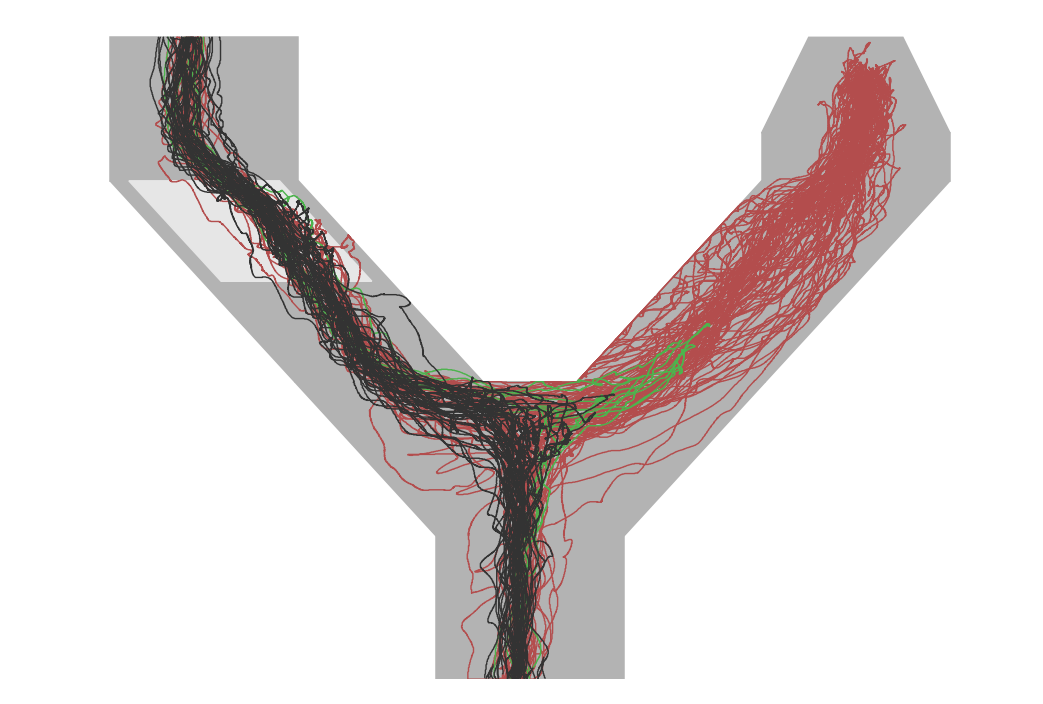

In [34]:
plt.figure(figsize=[18,12])
Id = 0
draw(maze[Id],False)
branchId = 3
keepW = trialEntered(branchId)
branchId = 5
keepE = trialEntered(branchId)

keep = trial[(keepW.curBranchId == True) & (keepE.curBranchId == True) & (trial.trialType == Id)].index.tolist()
print len(keep)
trace(session, keep, [0.7, 0.3, 0.3])
keep = trial[(keepW.curBranchId == True) & (keepE.curBranchId == False) & (trial.trialType == Id)].index.tolist()
print len(keep)
trace(session, keep, [0.3, 0.7, 0.3])
keep = trial[(keepW.curBranchId == False) & (trial.trialType == Id)].index.tolist()
print len(keep)
trace(session, keep, [0.2, 0.2, 0.2])
#keep = trial[(keepW.curBranchId == False) & (keepC.curBranchId == True) & (trial.trialType == Id) & (trial.index>15)].index.tolist()
#print len(keep)
#trace(session, keep, [0.2, 0.2, 0.2])

<Container object of 3 artists>

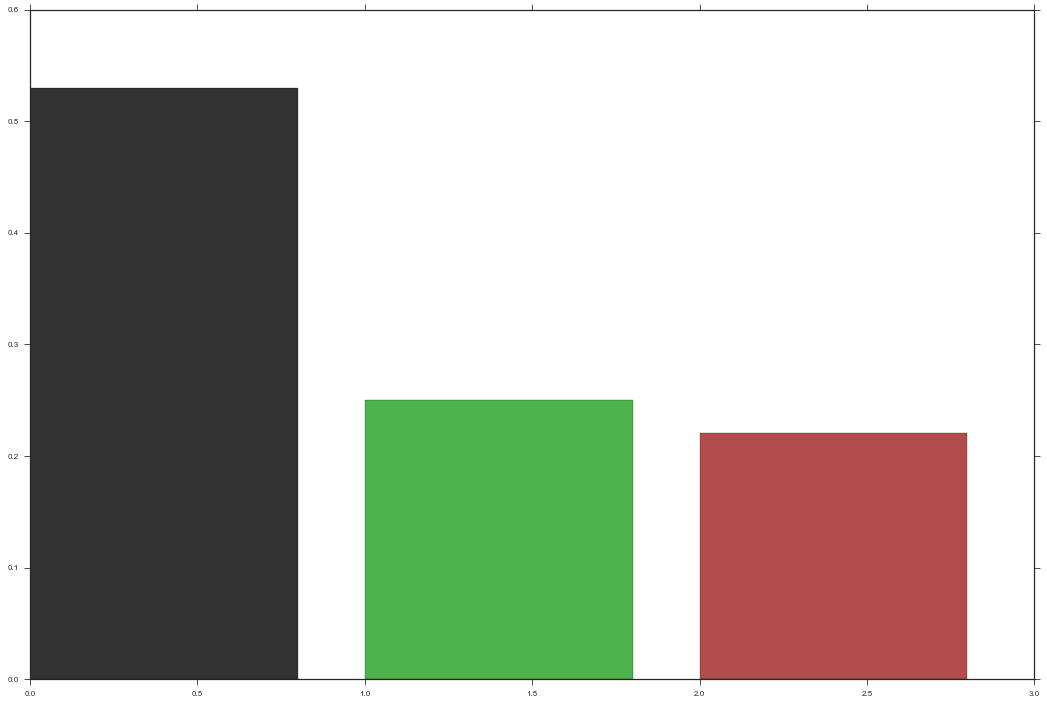

In [37]:
plt.figure(figsize=[18,12])
Id = 0
branchId = [2, 3, 5]
color = [[0.2, 0.2, 0.2], [0.3, 0.7, 0.3], [0.7, 0.3, 0.3]]
outcome = [sum(trialEntered(x)['curBranchId']==True) for x in branchId]
outcome = map(float, outcome)/np.sum(outcome)
#location = [np.mean(maze[Id]['branches'][x][0]) for x in branchId]
plt.bar(range(0,len(outcome)), outcome, color=color);
#sns.despine()